In [ ]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import keras

from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops
from skimage.measure import label
from tqdm import tqdm

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
%%capture
!unzip Processed.zip -d Dataset

In [ ]:
# UTILS

import matplotlib.pyplot as plt
import numpy as np

def visualize_learning_curve(H):
  epochs = len(H.history["loss"])
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["mae"], label="train_mae")
  plt.plot(np.arange(0, epochs), H.history["val_mae"], label="val_mae")
  plt.title("Training Loss and MAE")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/MAE")
  plt.legend()

from sklearn.metrics import classification_report

def evaluate_model(model, x, y):
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x, batch_size=128)
  print(classification_report(y, predictions.argmax(axis=1)))

In [ ]:
import pandas as pd
import cv2
from tqdm import tqdm

df = pd.read_csv("Dataset/Processed/labels_train.csv", index_col=0)

image_data = []
image_labels = []

for i in tqdm(range(len(df))):
  img = cv2.imread(f"Dataset/Processed/Train/cacao-{i}.jpg")
  image_data.append(img)

image_data = np.array(image_data)
image_labels = df["weight"].values

100%|██████████| 1612/1612 [00:00<00:00, 8502.68it/s]


In [ ]:
# Step 3: Split the Data into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42)


In [ ]:
from keras.applications import VGG16

VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in VGG16_model.layers:
    layer.trainable = False
    if layer.name == 'block5_conv1':
        break

model = Sequential()
model.add(VGG16_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,927,617 (60.76 MB)

 Trainable params: 5,932,545 (22.63 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, verbose=1, min_lr=1e-5)
]

datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True
)

# Fit the generator on your training data
datagen.fit(X_train)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 41.4000 - mae: 4.1272 - mape: 309.1429 - val_loss: 0.1263 - val_mae: 0.2935 - val_mape: 23.0880 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.2871 - mae: 0.4311 - mape: 30.8373 - val_loss: 0.2071 - val_mae: 0.3987 - val_mape: 31.5834 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.3105 - mae: 0.4544 - mape: 32.9840 - val_loss: 0.0498 - val_mae: 0.1731 - val_mape: 12.5892 - learning_rate: 0.0010
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.1656 - mae: 0.3229 - mape: 23.3770 - val_loss: 0.2481 - val_mae: 0.4502 - val_mape: 35.7823 - learning_rate: 0.0010
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.1968 - mae: 0.3497 - mape: 25.1853 - val_loss: 0.0681 - val_mae: 0.2140 - val_mape: 14.9176 - learning_rate: 0.0010
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.1615 - mae: 0.3262 - mape: 22.7774 - val_loss: 0

In [ ]:
val_loss, val_mae, val_mape = model.evaluate(X_val, y_val)
print(f"Validation MAE: {val_mae:.4f}")

# Step 8: Save the Model
model.save('cacao_bean_regression_cnn_model.h5')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0456 - mae: 0.1581 - mape: 12.4792


Validation MAE: 0.1519


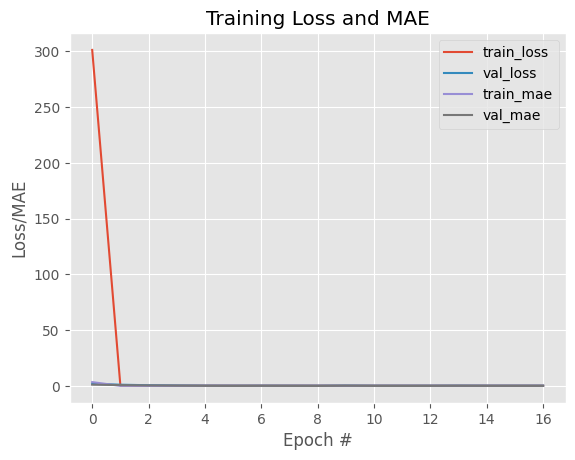

In [ ]:
visualize_learning_curve(history)

# TESTING

In [ ]:
%%capture
!unzip Test.zip -d Test

In [ ]:
def process_image(image):

    # Resize once and convert to grayscale
    image_resized = cv2.resize(image, (500, 300))
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

    # Thresholding and hole filling
    _, img = cv2.threshold(image_gray, 0, 1, cv2.THRESH_OTSU)
    img = 1 - img
    img = binary_fill_holes(img)

    # Calculate largest bounding box using regionprops
    lab, num = label(img, return_num=True)
    max_area = 0
    bbox = []

    for i in range(1, num + 1):
        object_region = (lab == i).astype('uint8')
        prop = regionprops(object_region)[0]
        area = prop.area
        if area > max_area:
            max_area = area
            bbox = prop.bbox


    # If max_area is too small, skip processing (early exit)
    if max_area < 1000:
        print(f"Max area too small: {max_area}")
        return None

    # Crop the image and apply the mask
    img_cropped = image_resized[bbox[0]: bbox[2], bbox[1]: bbox[3]]
    mask_cropped = img[bbox[0]: bbox[2], bbox[1]:bbox[3]]
    img_cropped = img_cropped * mask_cropped[..., None]

    old_image_height, old_image_width, channels = img_cropped.shape

    # create new image of desired size and color (blue) for padding
    new_image_width = 300
    new_image_height = 300
    color = (0,0,0)
    result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image
    result[y_center:y_center+old_image_height,
        x_center:x_center+old_image_width] = img_cropped

    result = cv2.resize(result, (100,100))


    return result


In [ ]:
df = pd.read_csv("labels_test.csv")

df.head()

classes = np.unique(df["Weight"])

images_test = []
labels_test = []


for i in tqdm(range(len(df))):
  path = df.iloc[i]["Image path"].replace("Dataset", "Test")


  image = cv2.imread(path)
  image = process_image(image)
  images_test.append(image)
  labels_test.append(df.iloc[i]["Weight"])


100%|██████████| 180/180 [00:26<00:00,  6.80it/s]


In [ ]:
predictions = []

for i in images_test:
  single_image = np.expand_dims(i, axis=0)
  predictions.append(model.predict(single_image, verbose=0)[0][0])



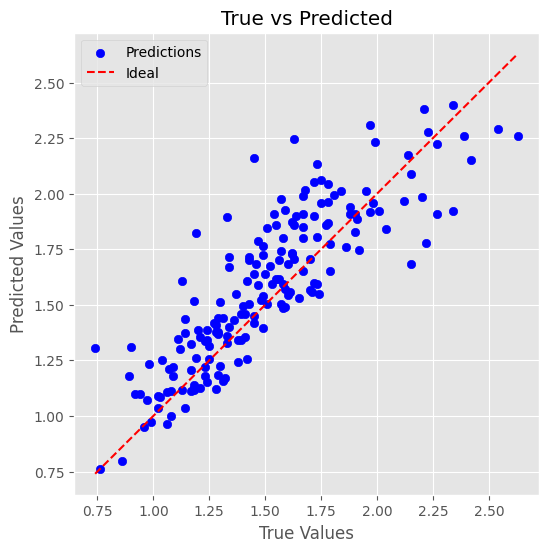

In [ ]:
# Scatter plot (True vs Predicted)
plt.figure(figsize=(6, 6))
plt.scatter(labels_test, predictions, color='blue', label='Predictions')
plt.plot([min(labels_test), max(labels_test)], [min(labels_test), max(labels_test)], 'r--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(labels_test, predictions)
mse = mean_squared_error(labels_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(labels_test, predictions)
mape = np.mean(np.abs((np.array(labels_test) - np.array(predictions)) / np.array(labels_test))) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 0.16
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.21
R-squared (R2) Score: 0.68
Mean Absolute Percentage Error (MAPE): 11.06%
